In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.graphics.api as smg
import statsmodels.stats.api as sms
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf
from scipy import stats
from matplotlib import pyplot as plt

import seaborn as sns

import pandas as pd
from sklearn import preprocessing

# Import the data

In [42]:
# Define what you want to observe
dim = "loss"  # "gain"
predictor_names = ["weight", ] + [f"{dim}__{p}" 
                                  for p in ("risk_aversion", "distortion", "precision", "side_bias")]
var_name = "DS"  # "EloRating"   #"oldDS"

col_names = [var_name, ] + predictor_names 

# Import data
df = pd.read_csv('data/export/param.csv', usecols=col_names)

In [43]:
# Normalize
min_max_scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df.columns,
             index=df.index)
print(df)

   loss__distortion  loss__risk_aversion  loss__precision  loss__side_bias  \
0          0.167110             0.987558         0.146790         0.003595   
1          1.000000             0.228382         0.015772         0.053811   
2          0.480614             0.000000         0.000000         0.019987   
3          0.414678             1.000000         0.069806         0.153691   
4          0.000000             0.335200         1.000000         1.000000   
5          0.354914             0.773168         0.026691         0.164448   
6          0.276998             0.373033         0.192331         0.000000   
7          0.707129             0.651593         0.294237         0.175048   

         DS    weight  
0  1.000000  0.876404  
1  0.924761  0.865169  
2  0.678344  0.640449  
3  0.267416  0.213483  
4  0.000000  0.000000  
5  0.639767  0.483146  
6  0.960276  1.000000  
7  0.264940  0.573034  


# Run regression analysis (OLS)

In [44]:
formula = f"{var_name} ~ "
for i in predictor_names:
    formula += f"+ {i}"
res = smf.ols(formula=formula, data=df).fit()
print(formula)
print(res.summary())

DS ~ + weight+ loss__risk_aversion+ loss__distortion+ loss__precision+ loss__side_bias
                            OLS Regression Results                            
Dep. Variable:                     DS   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     19.49
Date:                Sat, 27 Jun 2020   Prob (F-statistic):             0.0495
Time:                        14:26:30   Log-Likelihood:                 12.652
No. Observations:                   8   AIC:                            -13.30
Df Residuals:                       2   BIC:                            -12.83
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


In [45]:
print('Parameters: ', res.params)
print('R2: ', res.rsquared)

Parameters:  Intercept             -0.182982
weight                 1.544277
loss__risk_aversion    0.063529
loss__distortion      -0.358139
loss__precision       -1.563268
loss__side_bias        1.710618
dtype: float64
R2:  0.9798929935595281


# Compare the contribution of each predictor

## Coefficient plot

In [41]:
err_series_low = res.params - res.conf_int()[0]
err_series_high = res.conf_int()[1] - res.params

coef_df = pd.DataFrame({'coef': res.params.values[1:],
                        'err_low': err_series_low.values[1:],
                        'err_high': err_series_high.values[1:],
                        'predictor': err_series_low.index.values[1:]
                       })
coef_df

,coef,err_low,err_high,predictor
0,1.544277,1.231616,1.231616,weight
1,0.063529,0.553957,0.553957,gain__risk_aversion
2,-0.358139,0.678922,0.678922,gain__distortion
3,-1.563268,2.120280,2.120280,gain__precision
4,1.710618,2.808756,2.808756,gain__side_bias


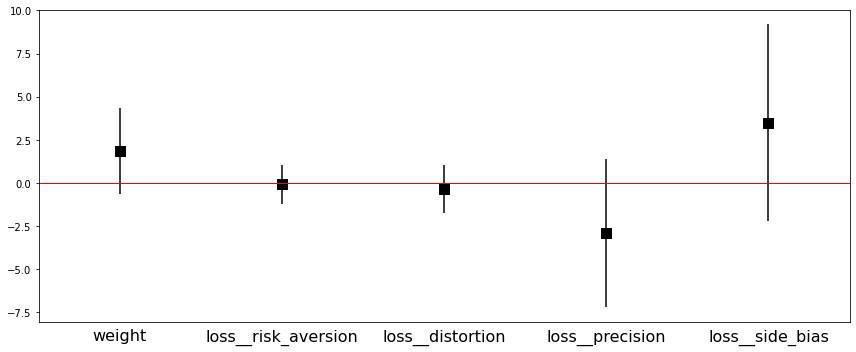

In [26]:
yerr = np.vstack((coef_df['err_low'], coef_df['err_high']))

fig, ax = plt.subplots(figsize=(12, 5))
coef_df.plot(x='predictor', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr=yerr, legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='-', color='red', linewidth=1)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(predictor_names, 
                       rotation=0, fontsize=16)
plt.tight_layout()

## Partial regression plot
Show the effect of adding another predictor to a model that already contains the other predictors

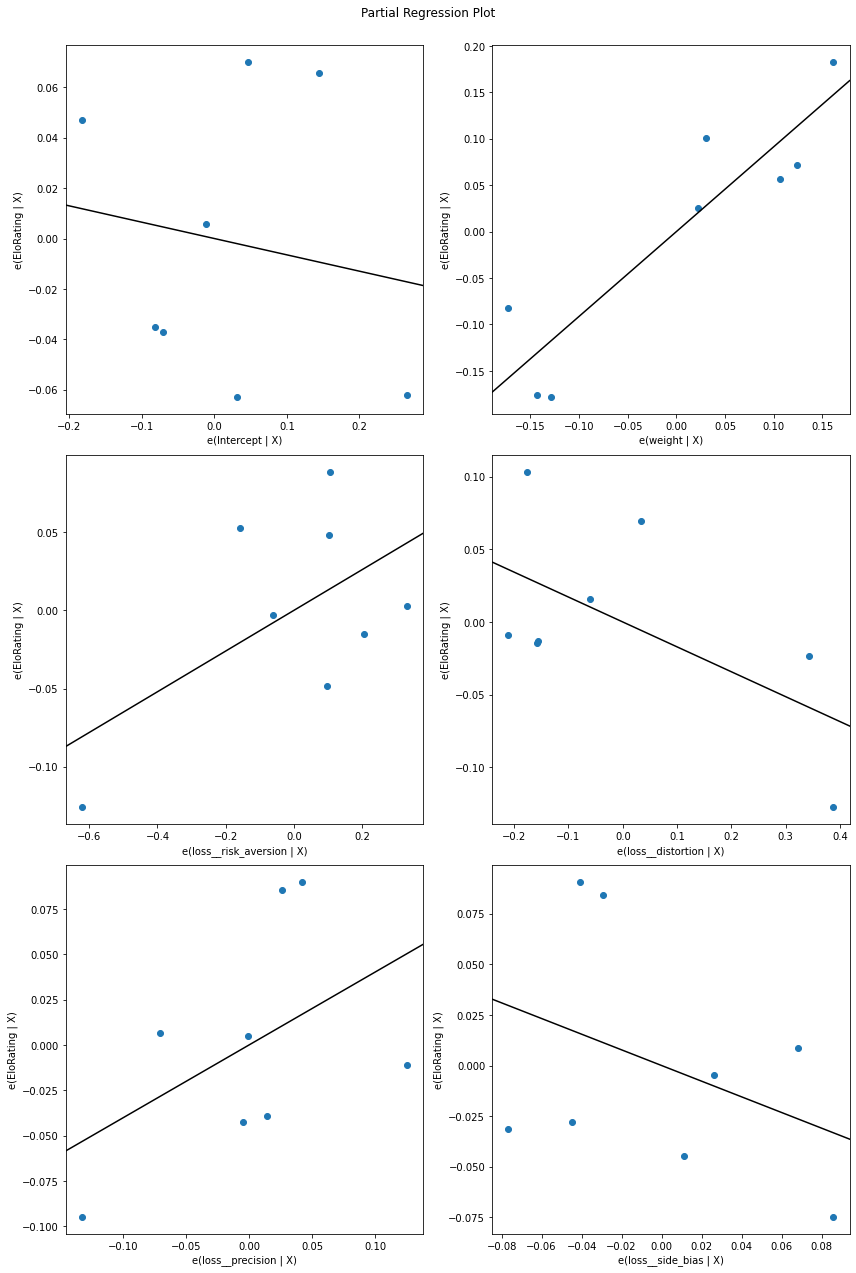

In [8]:
fig = plt.figure(figsize=(6*2, 6*3))
fig = sm.graphics.plot_partregress_grid(res, fig=fig)

## Component and component plus residual plots (partial residual plot)

Quite useless in the case of a single predictor (at this point, a scatter plot of the dependant variable vs the predictor value is enough), but useful in the case of multiple predictors. Contrary to dependant vs each predictor, the effect of other predictors is taken into account in these plots.

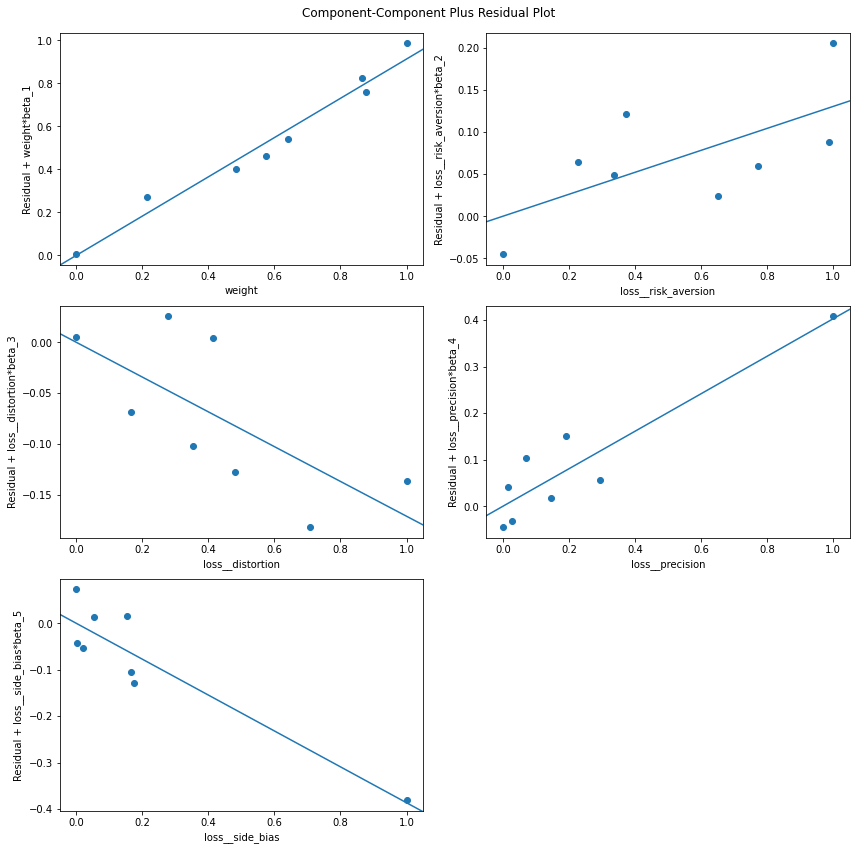

In [9]:
fig = plt.figure(figsize=(6*2, 6*int(len(predictor_names)/2)))
fig = sm.graphics.plot_ccpr_grid(res, fig=fig)

## Partial s squarred

Full model: EloRating ~ + weight+ loss__risk_aversion+ loss__distortion+ loss__precision+ loss__side_bias
R2=0.971795586259841

Reduced model (remove weight): EloRating ~ + loss__risk_aversion+ loss__distortion+ loss__precision+ loss__side_bias
R2=0.8382281734809724
weight leads to an improvement of R2 of 0.1336 (15.93%)
BIC: -0.35627805885157215

Reduced model (remove loss__risk_aversion): EloRating ~ + weight+ loss__distortion+ loss__precision+ loss__side_bias
R2=0.9583794110801456
loss__risk_aversion leads to an improvement of R2 of 0.0134 (1.40%)
BIC: -11.217013205468184

Reduced model (remove loss__distortion): EloRating ~ + weight+ loss__risk_aversion+ loss__precision+ loss__side_bias
R2=0.9563369144232557
loss__distortion leads to an improvement of R2 of 0.0155 (1.62%)
BIC: -10.833748799969108

Reduced model (remove loss__precision): EloRating ~ + weight+ loss__risk_aversion+ loss__distortion+ loss__side_bias
R2=0.9630475746657524
loss__precision leads to an improvement of R2 of

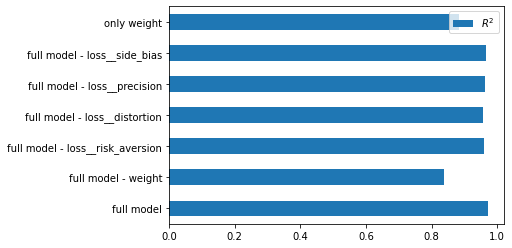

In [10]:
print(f"Full model: {formula}")
print(f"R2={res.rsquared}")
print()

val = [res.rsquared, ]

for i in predictor_names:
    new_predictor_names = [n for n in predictor_names if n != i]
    new_formula = f"{var_name} ~ "
    for j in new_predictor_names:
        new_formula += f"+ {j}"
    new_res = smf.ols(formula=new_formula, data=df).fit()
    diff = res.rsquared - new_res.rsquared
    print(f"Reduced model (remove {i}): {new_formula}")
    print(f"R2={new_res.rsquared}")
    print(f"{i} leads to an improvement of R2 of {diff:.4f} ({(res.rsquared/new_res.rsquared-1)*100:.2f}%)")
    print(f"BIC: {new_res.bic}")
    print()
    val.append(new_res.rsquared)
    
    
new_formula = f"{var_name} ~ weight"
new_res = smf.ols(formula=new_formula, data=df).fit()

print(f"Reduced model (remove {i}): {new_formula}")
print(f"R2={new_res.rsquared}")
print(f"BIC: {new_res.bic}")
val.append(new_res.rsquared)

lab = ["full model"] + [f"full model - {i}" for i in predictor_names] + ["only weight"]
    
df_rsq = pd.DataFrame({'$R^2$':val}, index=lab)
print(df_rsq)

ax = df_rsq.plot.barh(y='$R^2$', rot=0)

# Regression diagnostics
## Check for normality of residuals

In [11]:
# Statistical tests (H0 = dist is non-normal)
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(res.resid)
for n, m in zip(name, test):
    print(n, m)

Jarque-Bera 0.9244641272002896
Chi^2 two-tail prob. 0.6298761516526801
Skew 0.35798761735316675
Kurtosis 1.4964136722861305


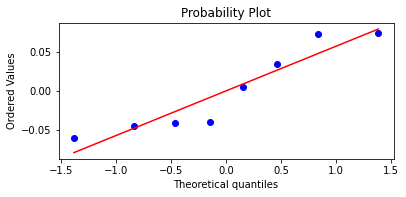

In [12]:
# Normal probability plot
fig, ax = plt.subplots(figsize=(6, 2.5))
stats.probplot(res.resid, plot=ax, fit=True)
plt.show()

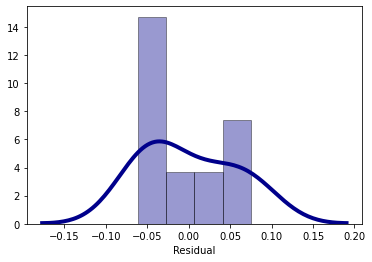

In [13]:
# Distribution of residuals
sns.distplot(res.resid, hist=True, kde=True,
             bins=4,
             color='darkblue',
             hist_kws={'edgecolor': 'black'},
             kde_kws={'linewidth': 4},
             axlabel='Residual'
            )
plt.show()

## Check for (absence of) multicollinearity between predictors

In [14]:
# Isolate predictors
predictors = df[predictor_names]

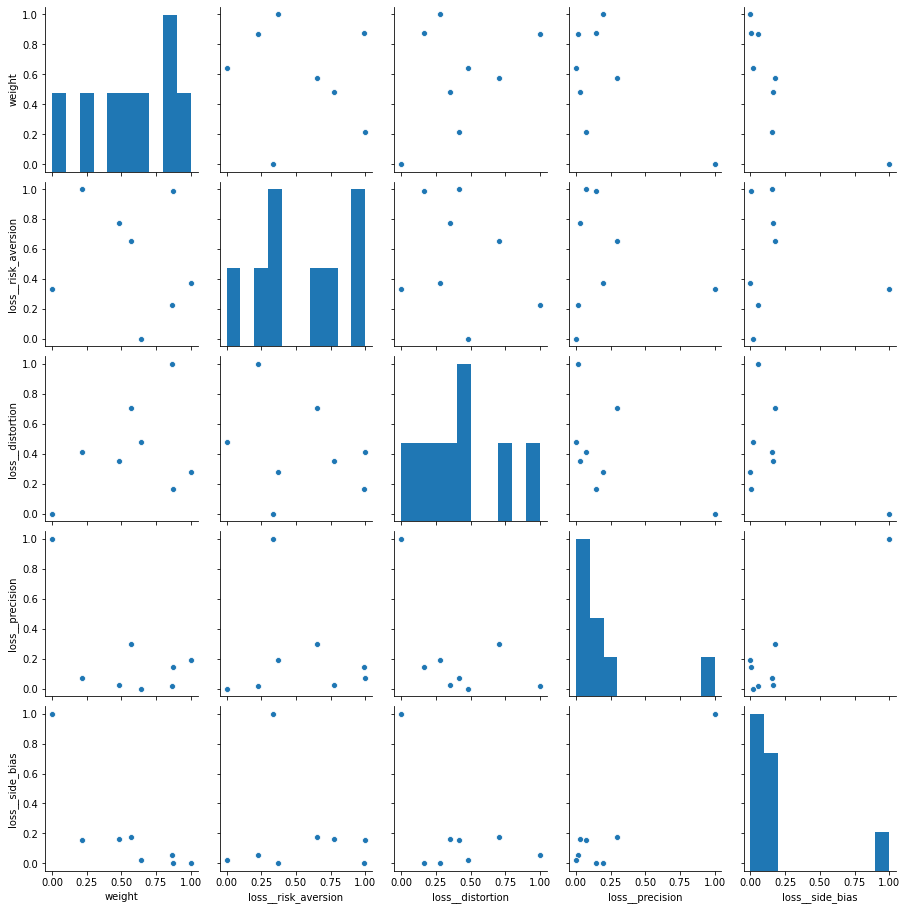

In [15]:
sns.pairplot(predictors)

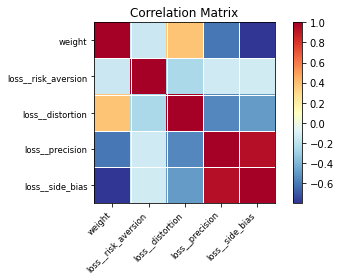

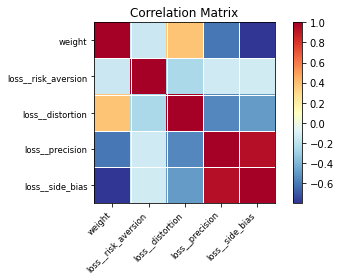

In [16]:
corr_matrix = predictors.corr(method='pearson')
smg.plot_corr(corr_matrix, xnames=predictors.columns)

In [17]:
# Statistical test (H0 = multicollinearity)
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sm.stats.diagnostic.het_breuschpagan(res.resid, res.model.exog)
for n, m in zip(name, test):
    print(n, m)

Lagrange multiplier statistic 4.99130243819355
p-value 0.4169425736158171
f-value 0.6635831399679436
f p-value 0.6925250445638953


In [18]:
# Condition number (the bigger, the better; 0=> maximal multicollinearity)
np.linalg.cond(res.model.exog)

33.983258575306245

## Check for homoscedasticity of residuals
What we don't want is heteroscedasticity => systematic change in the spread of the residuals over the range of measured values

Text(0, 0.5, 'Residuals (normalized)')

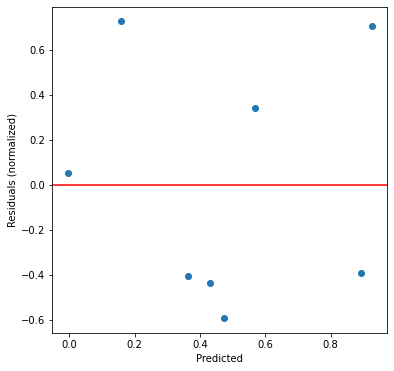

In [19]:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(res.predict(), res.resid_pearson)
    ax.axhline(0, color='red')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals (normalized)")

## Check for linearity

KeyError: 'MDS'

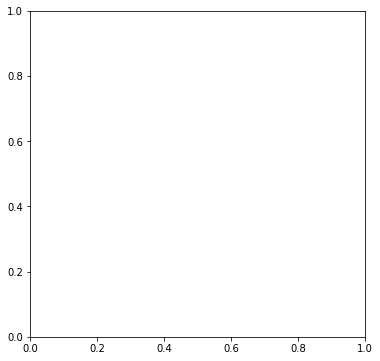

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(res.predict(), df["MDS"])
ax.plot((0,1), (0, 1), color="red")
ax.set_xlabel("Predicted")
ax.set_ylabel("Observed")

In [ ]:
# Check esperance of error (should be zero)
res.resid.mean()

In [ ]:
# Statistical test
name = ['t value', 'p value']
test = sms.linear_harvey_collier(res)
for n, m in zip(name, test):
    print(n, m)

**NB: The partial regression plot are also useful to check the linearity**

## Influence tests
Assess the influence of each data point on the model

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
fig = sm.graphics.influence_plot(res, ax=ax, criterion="cooks")

# Lasso

In [ ]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.0, normalize=True, max_iter=50000)
print(list(predictors.columns))
y = df[var_name]
X = predictors.to_numpy()
clf.fit(X, y)
print(clf.get_params())
print("coef", clf.coef_)
print('intercept', clf.intercept_)
print('score', clf.score(X, y))